# Supplementary Figure 3. Adulticide sensitivity analysis

Author: Katie Tiley (katherine.tiley@lshtm.ac.uk) <br>
Date: 05 Dec 22 <br>
<br>
Note: in the code RIDL refers to 1gSLT, and IIT refers to Male Wolbachia release

In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
from scipy import integrate as sp
import seaborn as sns
from tabulate import tabulate
import pandas as pd
import bisect
import time

### 1. Set up model
Parameters:

In [2]:
# MOSQUITO
alphaO = 0.5  # rate that eggs hatch into larvae
alphaL = 0.18  # rate that larvae pupate
alphaP = 1  # rate that pupae eclose
phi = 500*(1/14)    # number eggs laid per mosquito per day
muO = 0.01    # daily death rate of eggs
muL = 0.1*alphaL    # daily death rate of larvae
muP = 0.1*alphaP     # pupae death rate
muM = 1/14     # adult mosquito death rate
muF = 1/14     # adult female mosquito death rate

# density-dependence via Bellows 1981:
AA = 1   # determines the density at which mortality remains proportionate
BB = 0.5   # determines the 'abruptness' of density-dependence

# WOLBACHIA
fCI = 0.012   # prop of cytoplasmic incompatibility that fails 'sigma'
MT = 0    # prop of wolbachia females that don't successfully maternally transfer 'omega'
c = 0.5      # mating competitiveness of released wolbachia males
cv = 1   # coverage of adulticide
e = 1.2      # relative mortality of wolbachia adults compared to wild adults
RR = 0.02915       # release ratio of wolbachia eggs to wild type eggs
RRsupp = 1      # release ratio of wolbachia eggs to wild type eggs for suppression techniques

Initial conditions:
(equilibrium values previously defined in Supp)

In [3]:
O0 = 15947.608023052446
OW0 = 0
rOW0 = 0
OS0 = 0
L0 = 40271.71074193975
LW0 = 0
rLW0 = 0
LS0 = 0
P0 = 32.67541200187585
PW0 = 0
rPW0 = 0
PS0 = 0
M0 = 228.72754035145144
MW0 = 0
MS0 = 0
F0 = 228.72754035145144
FW0 = 0

Wolbachia release function:

In [4]:
start_wol = 200

def pulseN(t, start_wol=start_wol, releasenumber=5, frequency=14):    
    for i in range(0,releasenumber,1):
        if round(t) == start_wol + (frequency*i):
            return 0 #O0
    else:
        return 0

Suppression functions:

In [5]:
# IIT

def IIT(t, releasenumber=1, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

In [6]:
# SIT / RIDL

switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=1, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

In [7]:
# Environmental management

start_em = 193
stop_em = 200
em_eff = 1 #0.526

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [8]:
# Larvicides (e.g. guppies)

start_lv = 193
stop_lv = 200
lv_eff = 1 #5.95

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [9]:
# Adulticide

h = [] #needed to set adulticide pulses
for i in range(0, -1, -1):
    h.append((start_wol-7) - (7*i))
#h = start_wol

def ad(t):    
    ad_eff = 0 #4.9
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01: # and round(t) < h[1]: # un-comment according to number of releases
        return 0
#    elif round(t) > h[1]+0.01 and round(t) < h[2]:
#        return 0
#    elif round(t) > h[2]+0.01 and round(t) < h[3]:
#        return 0
#    elif round(t) > h[3]+0.01 and round(t) < h[4]:
#        return 0
#    elif round(t) > h[4]+0.01 and round(t) < h[5]:
#        return 0
#    elif round(t) > h[5]+0.01 and round(t) < h[6]:
#        return 0
#    elif round(t) > h[6]+0.01 and round(t) < h[7]:
#        return 0
#    elif round(t) > h[7]+0.01 and round(t) < h[8]:
#        return 0
#    elif round(t) > h[8]+0.01 and round(t) < h[9]:
#        return 0
#    elif round(t) > h[9]+0.01:
#        return 0
    else:
        return ad_eff

Model:

In [28]:
def deriv(y, t, fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch):
    
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = y
    
    #MOSQUITOES
    
    allfemales = 1+F+FW
    allmales = 1+M+MW+(MS*c)
    
    F_nothing = F + FW*MT 
    M_nothing = M + MW*fCI 
    
    F_wol = FW*(1-MT)
    
    #Eggs
    dOdt = em(t) * phi * F_nothing * M_nothing/allmales - alphaO*O - lv(t)*muO*O # eggs laid * females no-wol * (males no_wol / all males) (aka prop no-wol males)
    dOWdt = em(t) * phi * F_wol * (M+MW)/allmales - alphaO*OW - lv(t)*muO*OW 
    drOWdt = pulseN(t)*RR - alphaO*rOW - muO*rOW
    dOSdt = phi * allfemales * (MS*c)/allmales - alphaO*OS - muO*OS
    
    #Larvae
    dLdt =  alphaO*O - alphaL*L - lv(t)*muL*L
    dLWdt = alphaO*OW - alphaL*LW - lv(t)*muL*LW
    drLWdt = alphaO*rOW - alphaL*rLW - muL*rLW
    dLSdt = switch*alphaO*OS - alphaL*LS - muL*LS
    
    #Pupae 
    dPdt =  alphaL*(L/(1+((AA*(L+LW+LS))**BB))) - alphaP*P - lv(t)*muP*P 
    dPWdt = alphaL*(LW/(1+((AA*(L+LW+LS))**BB))) - alphaP*PW - lv(t)*muP*PW
    drPWdt = alphaL*(rLW/(1+((AA*(rLW))**BB))) - alphaP*rPW - muP*rPW 
    dPSdt = alphaL*(LS/(1+((AA*(L+LW+LS))**BB))) - alphaP*PS - muP*PS
        
    #Adult
    dMdt =  .5*alphaP*P - muM*M - ad(t)*M*cv
    dMWdt = IIT(t)*RRsupp + .5*alphaP*(PW+rPW) - muM*1.2*MW - ad(t)*MW*cv
    dMSdt = SIT(t)*RRsupp - muM*1.2*MS # + .5*alphaP*PS remove for 1gSLT
    
    dFdt =  .5*alphaP*P - muF*F - ad(t)*F*cv
    dFWdt = .5*alphaP*(PW+rPW) - muF*1.2*FW - ad(t)*FW*cv

    return dOdt, dOWdt, drOWdt, dOSdt, dLdt, dLWdt, drLWdt, dLSdt, dPdt, dPWdt, drPWdt, dPSdt, dMdt, dMWdt, dMSdt, dFdt, dFWdt

Model prerequisites:

In [29]:
t = np.linspace(0, 1500, 1501) # grid of time points (in days)
y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # initial condition vector

Run model:

In [30]:
ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)

O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

Visual check all suppression and Wolbachia functions are switched off:
(should see horizontal lines)

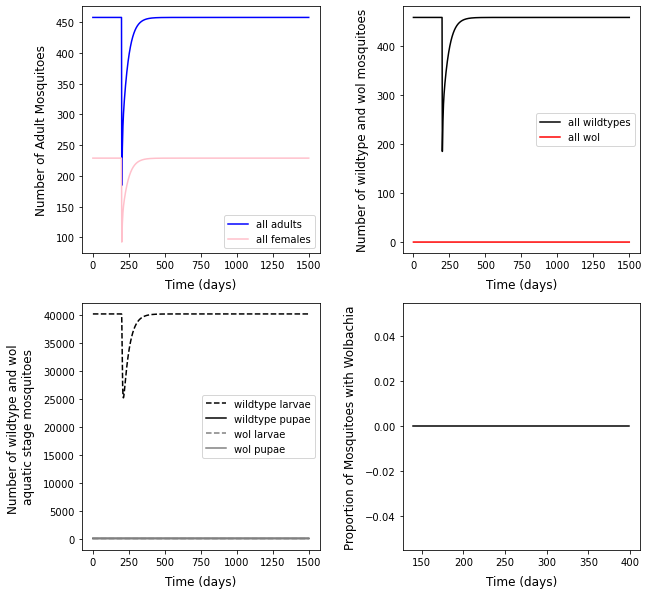

In [31]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10,10])

ax1.plot(t, F+FW+M+MW, 'blue', label='all adults')
ax1.plot(t, F+FW, 'pink', label='all females')
ax1.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax1.set_ylabel("Number of Adult Mosquitoes",fontsize=12, labelpad=8)
ax1.legend()

ax2.plot(t, M+F, 'black', label='all wildtypes')
ax2.plot(t, MW+FW, 'red', label='all wol')
ax2.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax2.set_ylabel("Number of wildtype and wol mosquitoes",fontsize=12, labelpad=8)
ax2.legend()

ax3.plot(t, L, 'black', linestyle='dashed', label='wildtype larvae')
ax3.plot(t, P, 'black', label='wildtype pupae')
ax3.plot(t, LW, 'grey', linestyle='dashed', label='wol larvae')
ax3.plot(t, PW, 'grey', label='wol pupae')
ax3.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax3.set_ylabel("Number of wildtype and wol \naquatic stage mosquitoes",fontsize=12, labelpad=8)
ax3.legend()

ax4.plot(t[140:400], (MW[140:400]+FW[140:400])/(MW[140:400]+FW[140:400]+M[140:400]+F[140:400]), 'black')
plt.xticks([150,200,250,300,350,400])
ax4.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax4.set_ylabel("Proportion of Mosquitoes with Wolbachia",fontsize=12, labelpad=8)


plt.subplots_adjust(wspace=.35)

### 2. Calculating efficacy parameters

#### Adulticide:
(run for 1 week)

In [14]:
# efficacy calculated as adult minimum population reached

start_time = time.time()

lower_bound = 93.950
upper_bound = 94.049

AD_decrease = []
AD_eff = []
eq = 457.4550807029029
start = 0
end = 50 #defines range of values to explore
nums = int(((end-start)*1000)+1)

for j in list(np.linspace(start,end,nums)):
        
    ad_eff = j
    h = start_wol
        
    def ad(t):
        if round(t) < h:
            return 0
        elif round(t) > h+0.01:
            return 0
        else:
            return ad_eff
    
    # run model
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T
    
    # calculate efficacy
    pop_min = min(M)+min(F)
    prop_decrease = (1-(pop_min/eq))*100
        
    # store results
    if lower_bound < prop_decrease < upper_bound:
        AD_decrease.append(prop_decrease)
        AD_eff.append(round(j,3))
        break


current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time/60,2),'minutes')

processing time: 4.4 minutes


In [15]:
AD_df = pd.DataFrame({'Weeks recovery': range(1,6)})
AD_df['Target efficacy'] = [94]
AD_df['Achieved efficacy'] = AD_decrease
AD_df['Efficacy parameter'] = AD_eff
AD_df['Coverage value'] = 'NaN'

AD_df

,Weeks recovery,Target efficacy,Achieved efficacy,Efficacy parameter,Coverage value
0,1,94,93.950529,4.441,NaN
1,2,94,93.950529,4.441,NaN
2,3,94,93.950529,4.441,NaN
3,4,94,93.950529,4.441,NaN
4,5,94,93.950529,4.441,NaN


In [27]:
lower_bound = [79.9]
upper_bound = [80.1]
weeks = [start_wol+7, start_wol+14, start_wol+21, start_wol+28, start_wol+35]
wk1 = []
wk2 = []
wk3 = []
wk4 = []
wk5 = []

h = start_wol  
def ad(t):
    if round(t) < h:
        return 0
    elif round(t) > h+0.01:
        return 0
    else:
        return AD_eff[0]


for i in range(0,5):
    
    for j in list(np.linspace(0, 30, 30001)):
    
        cv = j
    
        # run model
        ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
        O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T
    
        # calculate recovery
        pop_effect = M[weeks[i]] + F[weeks[i]]
        prop_recovery = (pop_effect/(M0+F0))*100
        
#        print(lower_bound, "<", prop_recovery, "<", upper_bound)
        
        # store results
        if lower_bound < prop_recovery < upper_bound:
            AD_df.loc[(AD_df['Weeks recovery'] == i+1), ['Coverage value']] = j
            print("found recovery in",i+1,"weeks")
            
            if i == 0:
                wk1 = M+F
            elif i == 1:
                wk2 = M+F
            elif i == 2:
                wk3 = M+F
            elif i == 3:
                wk4 = M+F
            elif i == 4:
                wk5 = M+F
            
            break
        elif prop_recovery < lower_bound:
            print("can't find recovery")
            break

found recovery in 1 weeks
found recovery in 2 weeks
found recovery in 3 weeks
found recovery in 4 weeks
found recovery in 5 weeks


In [32]:
cv1 = round(((AD_df.loc[(AD_df['Weeks recovery'] == 1), ['Coverage value']].values)*100)[0][0],3)
cv2 = round(((AD_df.loc[(AD_df['Weeks recovery'] == 2), ['Coverage value']].values)*100)[0][0],3)
cv3 = round(((AD_df.loc[(AD_df['Weeks recovery'] == 3), ['Coverage value']].values)*100)[0][0],3)
cv4 = round(((AD_df.loc[(AD_df['Weeks recovery'] == 4), ['Coverage value']].values)*100)[0][0],3)
cv5 = round(((AD_df.loc[(AD_df['Weeks recovery'] == 5), ['Coverage value']].values)*100)[0][0],3)

AD_df

,Weeks recovery,Target efficacy,Achieved efficacy,Efficacy parameter,Coverage value
0,1,94,93.950529,4.441,0.082
1,2,94,93.950529,4.441,0.111
2,3,94,93.950529,4.441,0.141
3,4,94,93.950529,4.441,0.178
4,5,94,93.950529,4.441,0.228


### 3. Plot

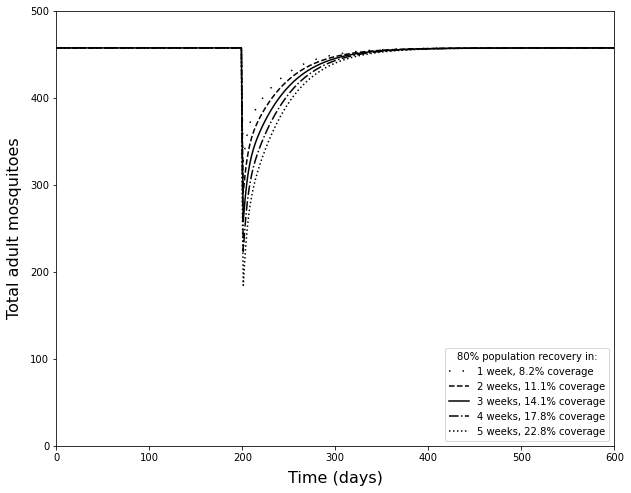

In [34]:
fig, ax2 = plt.subplots(1, 1, figsize=[10,8])

ax2.plot(t, wk1, 'black', label='1 week, {}% coverage'.format(cv1), linestyle = (0,(1, 8)))
ax2.plot(t, wk2, 'black', label='2 weeks, {}% coverage'.format(cv2), linestyle = "dashed")
ax2.plot(t, wk3, 'black', label='3 weeks, {}% coverage'.format(cv3))
ax2.plot(t, wk4, 'black', label='4 weeks, {}% coverage'.format(cv4), linestyle = "dashdot")
ax2.plot(t, wk5, 'black', label='5 weeks, {}% coverage'.format(cv5), linestyle = "dotted")
ax2.set_xlim(0,600)
ax2.set_ylim(0,500)
ax2.set_xlabel("Time (days)",fontsize=16, labelpad=8)
ax2.set_ylabel("Total adult mosquitoes",fontsize=16, labelpad=8)
ax2.legend(title = "80% population recovery in:", loc = 'lower right')

#plt.savefig('SFigure3.jpeg', dpi=300, orientation='portrait', bbox_inches=None)